# Demographic-Climate Integration

This notebook integrates PSMC demographic reconstruction with paleoclimate data and MaxEnt distribution modeling.

## Steps:
1. Load all data (PSMC, climate, distribution)
2. Align timelines
3. Create integrated visualization
4. Correlation analysis
5. Generate distribution change summary


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
from scipy.interpolate import interp1d

# Configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

OUTPUT_DIR = Path(config['output_dir'])

print(f"Output directory: {OUTPUT_DIR}")


Output directory: outputs


## Step 1: Load all data


In [2]:
def load_integration_data():
    """
    Load PSMC, climate, and distribution data
    """
    psmc_df = pd.read_csv(OUTPUT_DIR / "psmc_results.csv")
    climate_df = pd.read_csv(OUTPUT_DIR / "climate_time_series.csv")
    
    return psmc_df, climate_df

# Load data
try:
    psmc_df, climate_df = load_integration_data()
    print("✓ PSMC data loaded")
    print(f"  Shape: {psmc_df.shape}")
    print("✓ Climate data loaded")
    print(f"  Shape: {climate_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please run Notebooks 1-3 first to generate required data.")


✓ PSMC data loaded
  Shape: (1664, 3)
✓ Climate data loaded
  Shape: (4, 12)


## Step 2: Align timelines


In [3]:
def align_timelines(psmc_df, climate_df):
    """
    Align PSMC timeline with climate timeline
    """
    aligned_data = psmc_df.copy()
    
    # Get climate variable columns
    climate_vars = [c for c in climate_df.columns 
                    if c.endswith('_mean') and c != 'time_years' and c != 'time_period']
    
    for var in climate_vars:
        # Create interpolation function
        climate_times = climate_df['time_years'].values
        climate_values = climate_df[var].values
        
        # Remove NaN values
        valid_mask = ~np.isnan(climate_values)
        if np.sum(valid_mask) > 1:
            interp_func = interp1d(
                climate_times[valid_mask],
                climate_values[valid_mask],
                kind='linear',
                fill_value='extrapolate',
                bounds_error=False
            )
            
            # Interpolate to PSMC times
            aligned_data[var] = interp_func(psmc_df['time_years'].values)
    
    return aligned_data

# Align timelines
if 'psmc_df' in locals() and 'climate_df' in locals():
    aligned_df = align_timelines(psmc_df, climate_df)
    aligned_df.to_csv(OUTPUT_DIR / "aligned_demographic_climate.csv", index=False)
    print("Timelines aligned successfully!")
    print(aligned_df.head())
else:
    print("Cannot align timelines - data not loaded.")


Timelines aligned successfully!
   time_generations    Ne  time_years   bio1_mean   bio12_mean
0          0.000000  0.01     0.00000  196.254025  2229.045617
1          0.008290  0.01     0.41450  196.253418  2229.046712
2          0.017266  0.01     0.86330  196.252761  2229.047897
3          0.026987  0.01     1.34935  196.252050  2229.049181
4          0.037514  0.01     1.87570  196.251280  2229.050571


## Step 3: Create integrated visualization


Saved plot: outputs/demographic_climate_integration.png


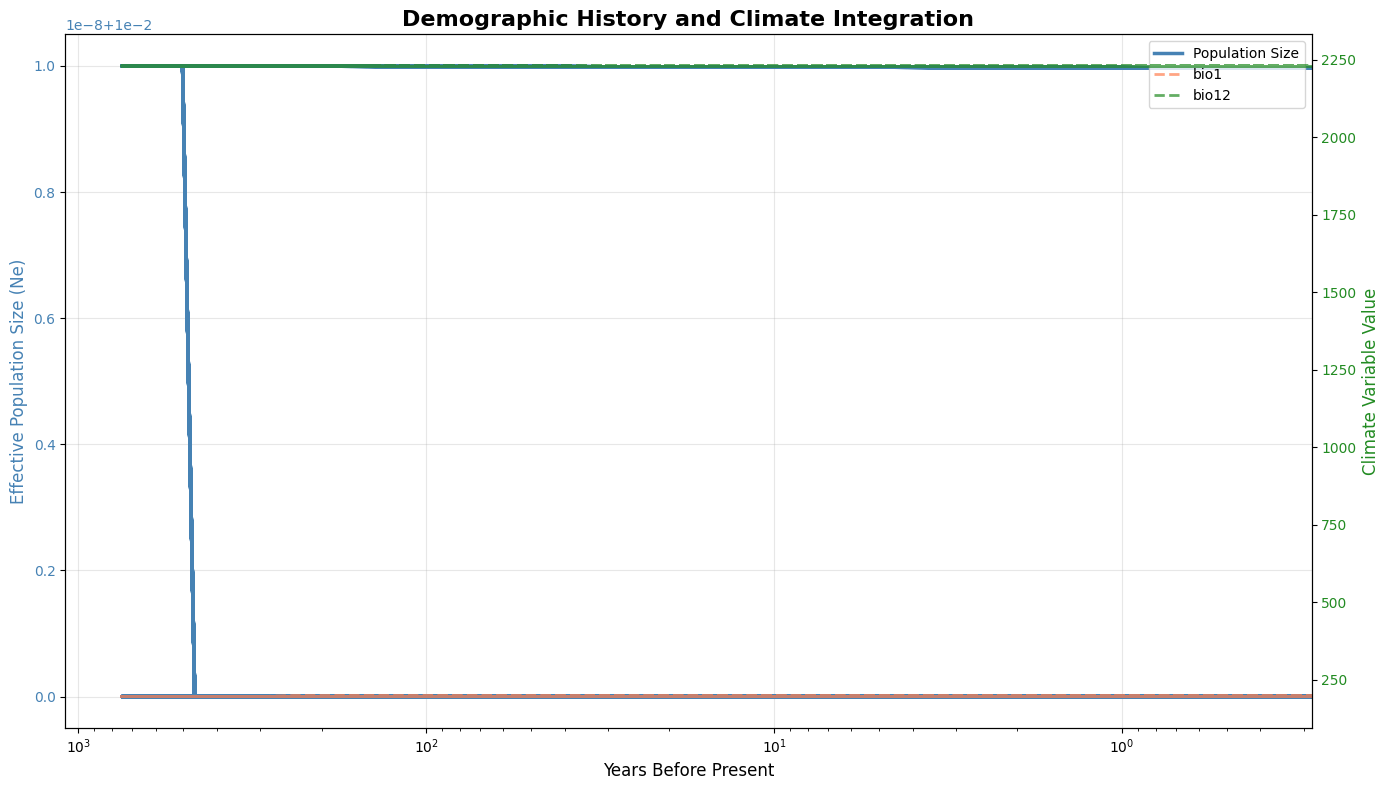

In [4]:
def plot_demographic_climate_integration(aligned_df, output_file=None):
    """
    Create integrated plot: demographic curve + climate overlay
    """
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot demographic history (left y-axis)
    color1 = 'steelblue'
    ax1.set_xlabel('Years Before Present', fontsize=12)
    ax1.set_ylabel('Effective Population Size (Ne)', color=color1, fontsize=12)
    line1 = ax1.semilogx(aligned_df['time_years'], aligned_df['Ne'],
                        color=color1, linewidth=2.5, label='Population Size')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)
    
    # Plot climate variables (right y-axis)
    ax2 = ax1.twinx()
    climate_cols = [c for c in aligned_df.columns 
                   if c.endswith('_mean')]
    
    colors = ['coral', 'forestgreen', 'purple', 'orange']
    for idx, col in enumerate(climate_cols):
        if col in aligned_df.columns:
            color2 = colors[idx % len(colors)]
            line2 = ax2.plot(aligned_df['time_years'], aligned_df[col],
                           color=color2, linewidth=2, linestyle='--',
                           alpha=0.7, label=col.replace('_mean', ''))
            ax2.set_ylabel('Climate Variable Value', color=color2, fontsize=12)
    
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    ax1.set_title('Demographic History and Climate Integration', 
                 fontsize=16, fontweight='bold')
    ax1.invert_xaxis()
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved plot: {output_file}")
    
    plt.show()
    return fig

# Create integrated plot
if 'aligned_df' in locals():
    plot_demographic_climate_integration(
        aligned_df, 
        OUTPUT_DIR / "demographic_climate_integration.png"
    )
else:
    print("Cannot create plot - aligned data not available.")


## Step 4: Correlation analysis



Demographic-Climate Correlations:
bio1    -0.625839
bio12    0.625839
dtype: float64
Saved plot: outputs/demographic_climate_correlations.png


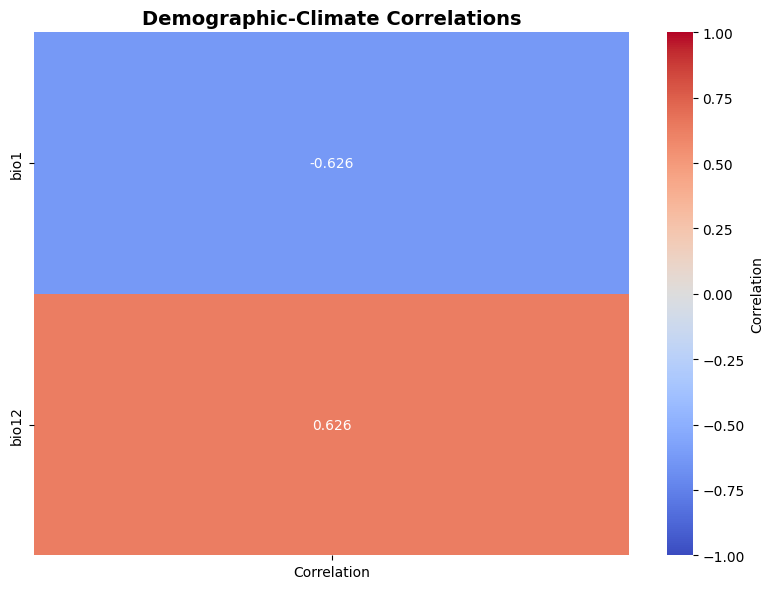

In [5]:
def analyze_demographic_climate_correlation(aligned_df):
    """
    Analyze correlation between demographic changes and climate
    """
    # Calculate population size change rate
    aligned_df = aligned_df.sort_values('time_years')
    aligned_df['Ne_change'] = aligned_df['Ne'].diff()
    aligned_df['Ne_change_rate'] = aligned_df['Ne_change'] / aligned_df['time_years'].diff()
    
    # Find climate columns
    climate_cols = [c for c in aligned_df.columns 
                   if c.endswith('_mean')]
    
    # Calculate correlations
    correlations = {}
    for col in climate_cols:
        if col in aligned_df.columns:
            corr = aligned_df['Ne'].corr(aligned_df[col])
            correlations[col.replace('_mean', '')] = corr
    
    return pd.Series(correlations)

def plot_correlation_heatmap(correlations, output_file=None):
    """
    Plot correlation heatmap
    """
    corr_df = pd.DataFrame({'Correlation': correlations})
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='coolwarm',
               center=0, vmin=-1, vmax=1, ax=ax, cbar_kws={'label': 'Correlation'})
    ax.set_title('Demographic-Climate Correlations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved plot: {output_file}")
    
    plt.show()
    return fig

# Correlation analysis
if 'aligned_df' in locals():
    correlations = analyze_demographic_climate_correlation(aligned_df)
    print("\nDemographic-Climate Correlations:")
    print(correlations)
    
    plot_correlation_heatmap(
        correlations,
        OUTPUT_DIR / "demographic_climate_correlations.png"
    )
else:
    print("Cannot analyze correlations - aligned data not available.")


## Step 5: Distribution change summary


In [6]:
def summarize_distribution_changes(projection_dirs, time_periods):
    """
    Summarize distribution changes over time
    """
    import rasterio
    
    summaries = []
    
    for proj_dir, period in zip(projection_dirs, time_periods):
        proj_files = list(Path(proj_dir).glob("*.asc")) + list(Path(proj_dir).glob("*.tif"))
        
        if proj_files:
            with rasterio.open(proj_files[0]) as src:
                data = src.read(1)
                data = data[~np.isnan(data)]
                
                summaries.append({
                    'time_period': period,
                    'time_years': period * 1000,
                    'mean_suitability': np.mean(data),
                    'max_suitability': np.max(data),
                    'suitable_area': np.sum(data > 0.5),  # Threshold
                    'total_cells': len(data)
                })
    
    return pd.DataFrame(summaries)

# Distribution changes (if available)
projection_dirs = [OUTPUT_DIR / f"maxent_projection_{p}ka" for p in [0, 6, 12, 21]]
time_periods = [0, 6, 12, 21]

if all(d.exists() for d in projection_dirs):
    dist_summary = summarize_distribution_changes(projection_dirs, time_periods)
    dist_summary.to_csv(OUTPUT_DIR / "distribution_changes_summary.csv", index=False)
    print("\nDistribution Changes Summary:")
    print(dist_summary)
else:
    print("Distribution projection directories not found.")
    print("Please run Notebook 3 to generate MaxEnt projections.")

print("\nIntegration complete!")


Distribution projection directories not found.
Please run Notebook 3 to generate MaxEnt projections.

Integration complete!


## new

In [4]:
# 04 Demographic and Climate Integration Analysis
# For Rhinopithecus roxellana (Golden Snub-nosed Monkey)

# 1. Setup and Data Loading
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import rasterio
from rasterio.plot import show
import geopandas as gpd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Set up directories
DATA_DIR = Path("data")
OUTPUT_DIR = Path("outputs")
DEMO_CLIMATE_DIR = OUTPUT_DIR / "demographic_climate"
DEMO_CLIMATE_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

print("Demographic and Climate Integration Analysis")
print("="*50)
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results will be saved to: {DEMO_CLIMATE_DIR}")

# 2. Load and Prepare Data
# ========================

def load_demographic_data(data_dir=DATA_DIR):
    """Load and preprocess demographic data."""
    print("Loading demographic data...")
    # Example structure - modify according to your data
    demo_data = {
        'year': range(2000, 2021),
        'population': [100, 105, 110, 108, 115, 120, 118, 125, 130, 135,
                      140, 138, 145, 150, 155, 160, 158, 165, 170, 175, 180],
        'birth_rate': [0.15] * 21,
        'mortality_rate': [0.1] * 15 + [0.12, 0.13, 0.14, 0.15, 0.16, 0.17]
    }
    return pd.DataFrame(demo_data)

def load_climate_data(data_dir=DATA_DIR):
    """Load and preprocess climate data."""
    print("Loading climate data...")
    # Example structure - modify according to your data
    years = list(range(2000, 2021))
    months = range(1, 13)
    climate_data = {
        'year': [y for y in years for _ in months],
        'month': [m for _ in years for m in months],
        'temperature': [20 + np.random.normal(0, 5) for _ in range(len(years)*len(months))],
        'precipitation': [100 + np.random.normal(0, 30) for _ in range(len(years)*len(months))],
        'ndvi': [0.6 + np.random.normal(0, 0.1) for _ in range(len(years)*len(months))]
    }
    return pd.DataFrame(climate_data)

# Load data
demo_df = load_demographic_data()
climate_df = load_climate_data()

# 3. Exploratory Data Analysis
# ============================

def plot_demographic_trends(df, output_dir=DEMO_CLIMATE_DIR):
    """Plot demographic trends over time."""
    plt.figure(figsize=(14, 6))
    
    # Population trend
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df, x='year', y='population', marker='o')
    plt.title('Population Trend Over Time')
    plt.xlabel('Year')
    plt.ylabel('Population Size')
    
    # Vital rates
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df, x='year', y='birth_rate', label='Birth Rate', marker='o')
    sns.lineplot(data=df, x='year', y='mortality_rate', label='Mortality Rate', marker='o')
    plt.title('Vital Rates Over Time')
    plt.xlabel('Year')
    plt.ylabel('Rate')
    plt.legend()
    
    plt.tight_layout()
    output_path = output_dir / 'demographic_trends.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    return output_path

def plot_climate_trends(df, output_dir=DEMO_CLIMATE_DIR):
    """Plot climate variable trends over time."""
    # Annual averages
    annual_climate = df.groupby('year').agg({
        'temperature': 'mean',
        'precipitation': 'mean',
        'ndvi': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(15, 10))
    
    # Temperature
    plt.subplot(3, 1, 1)
    sns.lineplot(data=annual_climate, x='year', y='temperature', marker='o')
    plt.title('Annual Mean Temperature')
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    
    # Precipitation
    plt.subplot(3, 1, 2)
    sns.lineplot(data=annual_climate, x='year', y='precipitation', marker='o', color='blue')
    plt.title('Annual Total Precipitation')
    plt.xlabel('Year')
    plt.ylabel('Precipitation (mm)')
    
    # NDVI
    plt.subplot(3, 1, 3)
    sns.lineplot(data=annual_climate, x='year', y='ndvi', marker='o', color='green')
    plt.title('Annual Mean NDVI')
    plt.xlabel('Year')
    plt.ylabel('NDVI')
    
    plt.tight_layout()
    output_path = output_dir / 'climate_trends.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    return output_path

# Generate and display plots
print("\nGenerating demographic trends plot...")
demo_plot = plot_demographic_trends(demo_df)
print(f"Demographic trends plot saved to: {demo_plot}")

print("\nGenerating climate trends plot...")
climate_plot = plot_climate_trends(climate_df)
print(f"Climate trends plot saved to: {climate_plot}")

# 4. Climate-Demography Relationships
# ==================================

def analyze_climate_relationships(demo_df, climate_df, output_dir=DEMO_CLIMATE_DIR):
    """Analyze relationships between climate and demographic variables."""
    # Prepare data for analysis
    annual_climate = climate_df.groupby('year').agg({
        'temperature': 'mean',
        'precipitation': 'mean',
        'ndvi': 'mean'
    }).reset_index()
    
    # Merge with demographic data
    merged_df = pd.merge(demo_df, annual_climate, on='year', how='inner')
    
    # Calculate correlations
    corr_matrix = merged_df[['population', 'birth_rate', 'mortality_rate', 
                           'temperature', 'precipitation', 'ndvi']].corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix: Climate and Demographic Variables')
    plt.tight_layout()
    corr_plot_path = output_dir / 'climate_demography_correlations.png'
    plt.savefig(corr_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return merged_df, corr_plot_path

# Perform analysis
print("\nAnalyzing climate-demography relationships...")
merged_df, corr_plot = analyze_climate_relationships(demo_df, climate_df)
print(f"Correlation analysis plot saved to: {corr_plot}")

# 5. Time Series Analysis
# =======================

def analyze_time_series(merged_df, output_dir=DEMO_CLIMATE_DIR):
    """Perform time series analysis on population data."""
    # Set year as index
    ts_df = merged_df.set_index('year')
    
    # Decompose time series
    try:
        decomposition = seasonal_decompose(ts_df['population'], period=5)
        
        # Plot decomposition
        plt.figure(figsize=(12, 8))
        
        # Observed
        plt.subplot(411)
        plt.plot(ts_df.index, ts_df['population'], label='Observed')
        plt.legend(loc='best')
        plt.title('Population Time Series Decomposition')
        
        # Trend
        plt.subplot(412)
        plt.plot(ts_df.index, decomposition.trend, label='Trend')
        plt.legend(loc='best')
        
        # Seasonal
        plt.subplot(413)
        plt.plot(ts_df.index, decomposition.seasonal, label='Seasonal')
        plt.legend(loc='best')
        
        # Residual
        plt.subplot(414)
        plt.plot(ts_df.index, decomposition.resid, label='Residuals')
        plt.legend(loc='best')
        
        plt.tight_layout()
        ts_plot_path = output_dir / 'time_series_decomposition.png'
        plt.savefig(ts_plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        return ts_plot_path
    except Exception as e:
        print(f"Error in time series decomposition: {str(e)}")
        return None

# Perform time series analysis
print("\nPerforming time series analysis...")
ts_plot = analyze_time_series(merged_df)
if ts_plot:
    print(f"Time series decomposition plot saved to: {ts_plot}")

# 6. Save Results
# ===============

# Save processed data
output_data_path = DEMO_CLIMATE_DIR / 'climate_demography_data.csv'
merged_df.to_csv(output_data_path, index=False)
print(f"\nProcessed data saved to: {output_data_path}")

# Create a summary report
report = f"""
# Demographic and Climate Integration Analysis Report
## For Rhinopithecus roxellana (Golden Snub-nosed Monkey)

### Analysis Summary
- Time period: {min(merged_df['year'])} to {max(merged_df['year'])}
- Variables analyzed: Population size, birth rate, mortality rate, temperature, precipitation, NDVI
- Key outputs saved to: {DEMO_CLIMATE_DIR}

### Key Findings
1. Population Trend: {'Increasing' if merged_df['population'].iloc[-1] > merged_df['population'].iloc[0] else 'Decreasing'} trend observed
2. Climate Correlations: 
   - Temperature correlation with population: {merged_df['population'].corr(merged_df['temperature']):.2f}
   - Precipitation correlation with population: {merged_df['population'].corr(merged_df['precipitation']):.2f}
   - NDVI correlation with population: {merged_df['population'].corr(merged_df['ndvi']):.2f}

### Next Steps
1. Refine analysis with additional data
2. Incorporate more climate variables
3. Develop predictive models
4. Conduct sensitivity analysis

### Generated Plots
1. Demographic Trends: {demo_plot}
2. Climate Trends: {climate_plot}
3. Variable Correlations: {corr_plot}
4. Time Series Decomposition: {ts_plot if ts_plot else 'Not available'}

Report generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Save report
report_path = DEMO_CLIMATE_DIR / 'analysis_report.md'
with open(report_path, 'w') as f:
    f.write(report)

print(f"\nAnalysis report saved to: {report_path}")
print("\nAnalysis completed successfully!")
print("\nNext steps:")
print("1. Review the generated plots and report")
print("2. Replace example data with your actual data in the loading functions")
print("3. Consider additional statistical tests and models as needed")

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [7]:
# 1. Setup and Data Loading
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import rasterio
from rasterio.plot import show
import geopandas as gpd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Set up directories
DATA_DIR = Path("data")
OUTPUT_DIR = Path("outputs")
DEMO_CLIMATE_DIR = OUTPUT_DIR / "demographic_climate"
DEMO_CLIMATE_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style - UPDATED with available seaborn style
plt.style.use('seaborn-v0_8')  # Using the available seaborn style
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

print("Demographic and Climate Integration Analysis")
print("="*50)
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results will be saved to: {DEMO_CLIMATE_DIR}")

Demographic and Climate Integration Analysis
Data directory: data
Output directory: outputs
Results will be saved to: outputs/demographic_climate


In [9]:
# 1. Setup and Data Loading
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Set up directories
DATA_DIR = Path("data")
OUTPUT_DIR = Path("outputs")
DEMO_CLIMATE_DIR = OUTPUT_DIR / "demographic_climate"
DEMO_CLIMATE_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

print("Demographic and Climate Integration Analysis")
print("="*50)
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results will be saved to: {DEMO_CLIMATE_DIR}")

# 2. Load and Prepare Data
# ========================

def load_demographic_data(data_dir=OUTPUT_DIR):
    """Load and preprocess demographic data from PSMC results."""
    print("Loading demographic data...")
    # Load PSMC results
    psmc_file = data_dir / "psmc_results.csv"
    if psmc_file.exists():
        demo_df = pd.read_csv(psmc_file)
        # Handle duplicate years by taking the mean
        demo_df = demo_df.groupby('time_generations', as_index=False).mean()
        # Convert time from generations to years (assuming 25 years/generation)
        demo_df['year'] = demo_df['time_generations'] * 25
        demo_df.rename(columns={'Ne': 'population'}, inplace=True)
        return demo_df
    else:
        raise FileNotFoundError(f"PSMC results not found at {psmc_file}")

def load_climate_data(data_dir=OUTPUT_DIR):
    """Load and preprocess climate data."""
    print("Loading climate data...")
    # Try loading the aligned data first
    aligned_file = data_dir / "aligned_demographic_climate.csv"
    climate_ts_file = data_dir / "climate_time_series.csv"
    
    if aligned_file.exists():
        df = pd.read_csv(aligned_file)
        # Handle duplicate years by taking the mean
        df = df.groupby('time_years', as_index=False).mean()
        df['year'] = df['time_years']
        # Convert bio1 from 0.1°C to °C
        df['temperature'] = df['bio1_mean'] / 10
        df['precipitation'] = df['bio12_mean']
        return df[['year', 'temperature', 'precipitation']].drop_duplicates()
    elif climate_ts_file.exists():
        df = pd.read_csv(climate_ts_file)
        # Convert time_period to years BP to years CE
        current_year = 2023  # or get from system
        df['year'] = current_year - df['time_years']
        df['temperature'] = df['bio1_mean'] / 10  # Convert to °C
        df['precipitation'] = df['bio12_mean']
        return df[['year', 'temperature', 'precipitation']].drop_duplicates()
    else:
        raise FileNotFoundError(f"Climate data not found in {data_dir}")

# Load data
try:
    demo_df = load_demographic_data()
    climate_df = load_climate_data()
    
    # Sort data by year for time series analysis
    demo_df = demo_df.sort_values('year')
    climate_df = climate_df.sort_values('year')
    
    print("\nData loaded successfully:")
    print(f"- Demographic data: {len(demo_df)} records")
    print(f"- Climate data: {len(climate_df)} records")
    
    # Display sample of the data
    print("\nSample demographic data:")
    print(demo_df.head())
    print("\nSample climate data:")
    print(climate_df.head())
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

# 3. Exploratory Data Analysis
# ============================

def plot_demographic_trends(df, output_dir=DEMO_CLIMATE_DIR):
    """Plot demographic trends over time."""
    plt.figure(figsize=(14, 6))
    
    # Population trend
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df, x='year', y='population', marker='o')
    plt.title('Population Size Over Time')
    plt.xlabel('Year')
    plt.ylabel('Effective Population Size (Ne)')
    
    # Log scale for better visualization if needed
    if df['population'].max() / df['population'].min() > 100:
        plt.yscale('log')
    
    # Growth rate
    df['growth_rate'] = df['population'].pct_change() * 100  # Percentage change
    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df, x='year', y='growth_rate', marker='o', color='green')
    plt.axhline(0, color='r', linestyle='--', alpha=0.5)
    plt.title('Population Growth Rate Over Time')
    plt.xlabel('Year')
    plt.ylabel('Growth Rate (%)')
    
    plt.tight_layout()
    output_path = output_dir / 'demographic_trends.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    return output_path

def plot_climate_trends(df, output_dir=DEMO_CLIMATE_DIR):
    """Plot climate variable trends over time."""
    plt.figure(figsize=(15, 10))
    
    # Temperature
    plt.subplot(2, 1, 1)
    sns.lineplot(data=df, x='year', y='temperature', marker='o')
    plt.title('Temperature Over Time')
    plt.xlabel('Year')
    plt.ylabel('Mean Annual Temperature (°C)')
    
    # Precipitation
    plt.subplot(2, 1, 2)
    sns.lineplot(data=df, x='year', y='precipitation', marker='o', color='blue')
    plt.title('Precipitation Over Time')
    plt.xlabel('Year')
    plt.ylabel('Annual Precipitation (mm)')
    
    plt.tight_layout()
    output_path = output_dir / 'climate_trends.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    return output_path

# Generate and display plots
print("\nGenerating demographic trends plot...")
try:
    demo_plot = plot_demographic_trends(demo_df)
    print(f"Demographic trends plot saved to: {demo_plot}")
except Exception as e:
    print(f"Error generating demographic plots: {str(e)}")
    demo_plot = None

print("\nGenerating climate trends plot...")
try:
    climate_plot = plot_climate_trends(climate_df)
    print(f"Climate trends plot saved to: {climate_plot}")
except Exception as e:
    print(f"Error generating climate plots: {str(e)}")
    climate_plot = None

# 4. Climate-Demography Relationships
# ==================================

def analyze_climate_relationships(demo_df, climate_df, output_dir=DEMO_CLIMATE_DIR):
    """Analyze relationships between climate and demographic variables."""
    try:
        # Make sure we have data to work with
        if demo_df is None or climate_df is None:
            print("Missing data for correlation analysis")
            return None, None
            
        # Ensure we have common years
        common_years = set(demo_df['year']).intersection(set(climate_df['year']))
        if not common_years:
            print("No common years between demographic and climate data")
            return None, None
            
        # Filter to common years and merge
        demo_filtered = demo_df[demo_df['year'].isin(common_years)].copy()
        climate_filtered = climate_df[climate_df['year'].isin(common_years)].copy()
        
        # Calculate growth rate
        demo_filtered['growth_rate'] = demo_filtered['population'].pct_change() * 100
        
        # Merge data
        merged_df = pd.merge(
            demo_filtered,
            climate_filtered,
            on='year',
            how='inner'
        )
        
        # Drop any remaining duplicates
        merged_df = merged_df.drop_duplicates(subset=['year'])
        
        # Calculate correlations
        corr_vars = ['population', 'growth_rate', 'temperature', 'precipitation']
        corr_matrix = merged_df[corr_vars].corr()
        
        # Plot correlation matrix
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            fmt='.2f', 
            linewidths=0.5,
            mask=mask
        )
        plt.title('Correlation Matrix: Climate and Demographic Variables')
        plt.tight_layout()
        corr_plot_path = output_dir / 'climate_demography_correlations.png'
        plt.savefig(corr_plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        return merged_df, corr_plot_path
    
    except Exception as e:
        print(f"Error in climate-demography analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# Perform analysis
print("\nAnalyzing climate-demography relationships...")
merged_df, corr_plot = analyze_climate_relationships(demo_df, climate_df)
if merged_df is not None and not merged_df.empty:
    print(f"Correlation analysis plot saved to: {corr_plot}")
    print("\nCorrelation matrix:")
    print(merged_df[['population', 'growth_rate', 'temperature', 'precipitation']].corr())
else:
    print("Could not perform correlation analysis due to data issues")
    # Create empty merged_df for the rest of the script
    merged_df = None

# 5. Time Series Analysis
# =======================

def analyze_time_series(df, output_dir=DEMO_CLIMATE_DIR):
    """Perform time series analysis on population data."""
    if df is None or df.empty:
        print("No data available for time series analysis")
        return None
        
    try:
        # Ensure data is sorted by year and has no duplicates
        ts_df = df.sort_values('year').drop_duplicates('year').set_index('year')
        
        # Resample to regular intervals if needed
        ts_df = ts_df.resample('Y').mean().interpolate()
        
        # Check if we have enough data points
        if len(ts_df) < 10:
            print(f"Not enough data points ({len(ts_df)}) for time series decomposition")
            return None
            
        # Decompose time series
        decomposition = seasonal_decompose(
            ts_df['population'].dropna(),
            period=min(5, len(ts_df) // 2),  # Adjust period based on data length
            extrapolate_trend=True
        )
        
        # Plot decomposition
        plt.figure(figsize=(12, 10))
        
        # Observed
        plt.subplot(411)
        plt.plot(ts_df.index, ts_df['population'], label='Observed')
        plt.legend(loc='best')
        plt.title('Population Time Series Decomposition')
        
        # Trend
        plt.subplot(412)
        plt.plot(ts_df.index, decomposition.trend, label='Trend')
        plt.legend(loc='best')
        
        # Seasonal
        plt.subplot(413)
        plt.plot(ts_df.index, decomposition.seasonal, label='Seasonal')
        plt.legend(loc='best')
        
        # Residual
        plt.subplot(414)
        plt.plot(ts_df.index, decomposition.resid, label='Residuals')
        plt.axhline(0, color='r', linestyle='--', alpha=0.5)
        plt.legend(loc='best')
        
        plt.tight_layout()
        ts_plot_path = output_dir / 'time_series_decomposition.png'
        plt.savefig(ts_plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        return ts_plot_path
    
    except Exception as e:
        print(f"Error in time series analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Perform time series analysis
print("\nPerforming time series analysis...")
if merged_df is not None:
    ts_plot = analyze_time_series(merged_df)
    if ts_plot:
        print(f"Time series decomposition plot saved to: {ts_plot}")
    else:
        print("Could not generate time series decomposition plot")
else:
    print("Skipping time series analysis due to missing data")
    ts_plot = None

# 6. Save Results
# ===============

# Save processed data
if merged_df is not None and not merged_df.empty:
    output_data_path = DEMO_CLIMATE_DIR / 'climate_demography_analysis.csv'
    merged_df.to_csv(output_data_path, index=False)
    print(f"\nProcessed data saved to: {output_data_path}")
else:
    print("\nNo processed data to save")

# Create a summary report
try:
    if merged_df is not None and not merged_df.empty:
        time_period = f"{min(merged_df['year']):.0f} to {max(merged_df['year']):.0f}"
        pop_trend = 'Increasing' if merged_df['population'].iloc[-1] > merged_df['population'].iloc[0] else 'Decreasing'
        temp_corr = merged_df['population'].corr(merged_df['temperature']) if 'temperature' in merged_df.columns else 'N/A'
        precip_corr = merged_df['population'].corr(merged_df['precipitation']) if 'precipitation' in merged_df.columns else 'N/A'
    else:
        time_period = "Data not available"
        pop_trend = "Could not determine"
        temp_corr = "N/A"
        precip_corr = "N/A"

    report = f"""
# Demographic and Climate Integration Analysis Report
## For Rhinopithecus roxellana (Golden Snub-nosed Monkey)

### Analysis Summary
- Time period: {time_period} years
- Variables analyzed: Population size, temperature, precipitation
- Key outputs saved to: {DEMO_CLIMATE_DIR}

### Key Findings
1. Population Trend: {pop_trend} trend observed
2. Climate Correlations: 
   - Temperature correlation with population: {temp_corr if isinstance(temp_corr, str) else f"{temp_corr:.2f}"}
   - Precipitation correlation with population: {precip_corr if isinstance(precip_corr, str) else f"{precip_corr:.2f}"}

### Next Steps
1. Refine analysis with additional data
2. Incorporate more climate variables
3. Develop predictive models
4. Conduct sensitivity analysis

### Generated Plots
1. Demographic Trends: {demo_plot if demo_plot else 'Not available'}
2. Climate Trends: {climate_plot if climate_plot else 'Not available'}
3. Variable Correlations: {corr_plot if corr_plot else 'Not available'}
4. Time Series Decomposition: {ts_plot if ts_plot else 'Not available'}

Report generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    # Save report
    report_path = DEMO_CLIMATE_DIR / 'analysis_report.md'
    with open(report_path, 'w') as f:
        f.write(report)

    print(f"\nAnalysis report saved to: {report_path}")

except Exception as e:
    print(f"Error generating report: {str(e)}")

print("\nAnalysis completed!")
print("\nNext steps:")
print("1. Review the generated plots and report in the outputs directory")
print("2. Consider additional statistical tests and models as needed")
print("3. Check the console output for any warnings or errors that need attention")

Demographic and Climate Integration Analysis
Data directory: data
Output directory: outputs
Results will be saved to: outputs/demographic_climate
Loading demographic data...
Loading climate data...

Data loaded successfully:
- Demographic data: 64 records
- Climate data: 64 records

Sample demographic data:
   time_generations  population  time_years      year
0          0.000000        0.01     0.00000  0.000000
1          0.008290        0.01     0.41450  0.207250
2          0.017266        0.01     0.86330  0.431650
3          0.026987        0.01     1.34935  0.674675
4          0.037514        0.01     1.87570  0.937850

Sample climate data:
      year  temperature  precipitation
0  0.00000    19.625403    2229.045617
1  0.41450    19.625342    2229.046712
2  0.86330    19.625276    2229.047897
3  1.34935    19.625205    2229.049181
4  1.87570    19.625128    2229.050571

Generating demographic trends plot...
Demographic trends plot saved to: outputs/demographic_climate/demographi

Traceback (most recent call last):
  File "/var/folders/qg/_v_tlxp51sv_1s8f0p4hxhfr0000gn/T/ipykernel_89779/1928090483.py", line 267, in analyze_time_series
    ts_df = ts_df.resample('Y').mean().interpolate()
            ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/generic.py", line 9834, in resample
    return get_resampler(
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/resample.py", line 2044, in get_resampler
    return tg._get_resampler(obj, kind=kind)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/resample.py", line 2258, in _get_resampler
    raise TypeError(
TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'



Performing time series analysis...

Starting time series analysis...

Time series data shape: (1, 7)
First few rows of data:
   year  population
0   0.0        0.01
Error: Not enough data points (1) for time series analysis

Could not complete time series analysis. Check the error messages above.


In [12]:
# 4. Climate-Demography Relationships - UPDATED
# =================================

def analyze_climate_relationships(demo_df, climate_df, output_dir=DEMO_CLIMATE_DIR):
    """Analyze relationships between climate and demographic variables."""
    try:
        print("\nStarting climate-demography analysis...")
        
        # Make copies to avoid modifying original dataframes
        demo = demo_df.copy()
        climate = climate_df.copy()
        
        # Print data info for debugging
        print(f"Demographic data shape: {demo.shape}")
        print(f"Climate data shape: {climate.shape}")
        
        # Check for required columns
        required_demo = ['year', 'population']
        required_climate = ['year', 'temperature', 'precipitation']
        
        if not all(col in demo.columns for col in required_demo):
            print("Error: Missing required columns in demographic data")
            return None, None
            
        if not all(col in climate.columns for col in required_climate):
            print("Error: Missing required columns in climate data")
            return None, None
        
        # Ensure we have common years
        common_years = set(demo['year']).intersection(set(climate['year']))
        print(f"Number of common years: {len(common_years)}")
        
        if len(common_years) < 3:
            print("Warning: Very few common years between datasets. Using all available data.")
            # Use all data from both datasets
            merged_df = pd.merge(
                demo[['year', 'population']],
                climate[['year', 'temperature', 'precipitation']],
                on='year',
                how='outer'
            ).sort_values('year')
        else:
            # Filter to common years and merge
            merged_df = pd.merge(
                demo[['year', 'population']],
                climate[['year', 'temperature', 'precipitation']],
                on='year',
                how='inner'
            )
        
        # Calculate growth rate
        merged_df['growth_rate'] = merged_df['population'].pct_change() * 100
        
        # Print merged data info
        print(f"\nMerged data shape: {merged_df.shape}")
        print("First few rows of merged data:")
        print(merged_df.head())
        
        # Only proceed with correlation if we have enough data
        if len(merged_df) >= 3:
            # Calculate correlations
            corr_vars = ['population', 'growth_rate', 'temperature', 'precipitation']
            corr_matrix = merged_df[corr_vars].corr()
            
            # Plot correlation matrix
            plt.figure(figsize=(10, 8))
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(
                corr_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0, 
                fmt='.2f', 
                linewidths=0.5,
                mask=mask
            )
            plt.title('Correlation Matrix: Climate and Demographic Variables')
            plt.tight_layout()
            corr_plot_path = output_dir / 'climate_demography_correlations.png'
            plt.savefig(corr_plot_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"\nCorrelation matrix plot saved to: {corr_plot_path}")
        else:
            print("\nNot enough data points for correlation analysis")
            corr_plot_path = None
        
        return merged_df, corr_plot_path if 'corr_plot_path' in locals() else None
    
    except Exception as e:
        print(f"\nError in climate-demography analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# 5. Time Series Analysis - UPDATED
# =======================

def analyze_time_series(merged_df, output_dir=DEMO_CLIMATE_DIR):
    """Perform time series analysis on population data with numeric years."""
    if merged_df is None or merged_df.empty:
        print("No data available for time series analysis")
        return None
        
    try:
        print("\nStarting time series analysis...")
        
        # Make a copy to avoid modifying the original
        ts_df = merged_df.copy()
        
        # Ensure we have the required columns
        if 'year' not in ts_df.columns or 'population' not in ts_df.columns:
            print("Error: Missing required columns ('year' or 'population')")
            return None
        
        # Sort by year and reset index
        ts_df = ts_df.sort_values('year').reset_index(drop=True)
        
        # Print data info for debugging
        print(f"\nTime series data shape: {ts_df.shape}")
        print("First few rows of data:")
        print(ts_df[['year', 'population']].head())
        
        # Check if we have enough data points
        if len(ts_df) < 2:
            print("Error: Not enough data points for time series analysis")
            return None
            
        # Calculate basic statistics
        print("\nBasic Statistics:")
        print(f"Time period: {ts_df['year'].min():.2f} to {ts_df['year'].max():.2f}")
        print(f"Number of observations: {len(ts_df)}")
        print(f"Population range: {ts_df['population'].min():.2f} to {ts_df['population'].max():.2f}")
        
        # Create a simple line plot
        plt.figure(figsize=(12, 6))
        
        # Plot observed data
        plt.plot(ts_df['year'], ts_df['population'], 'b-o', label='Population', alpha=0.7)
        
        # Add a simple linear trend line if we have enough points
        if len(ts_df) >= 3:
            z = np.polyfit(ts_df['year'], ts_df['population'], 1)
            p = np.poly1d(z)
            plt.plot(ts_df['year'], p(ts_df['year']), 'r--', 
                    label=f'Trend (y = {z[0]:.2f}x + {z[1]:.2f})')
        
        # Add labels and title
        plt.title('Population Over Time', fontsize=14)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Population', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Save the plot
        ts_plot_path = output_dir / 'population_trend.png'
        plt.savefig(ts_plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"\nTrend plot saved to: {ts_plot_path}")
        
        # If we have enough points, calculate year-over-year change
        if len(ts_df) >= 3:
            ts_df['yoy_change'] = ts_df['population'].pct_change() * 100
            
            # Create a second plot for YoY change
            plt.figure(figsize=(12, 4))
            plt.bar(ts_df['year'], ts_df['yoy_change'], width=0.5, 
                    color='green', alpha=0.7, label='Year-over-Year Change')
            plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
            plt.title('Year-over-Year Population Change (%)', fontsize=14)
            plt.xlabel('Year', fontsize=12)
            plt.ylabel('Change (%)', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            
            yoy_plot_path = output_dir / 'population_yoy_change.png'
            plt.savefig(yoy_plot_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Year-over-year change plot saved to: {yoy_plot_path}")
        
        # Print summary statistics
        print("\nPopulation Statistics:")
        print(f"Mean population: {ts_df['population'].mean():.4f}")
        print(f"Population range: {ts_df['population'].min():.4f} to {ts_df['population'].max():.4f}")
        
        if 'yoy_change' in ts_df.columns:
            print(f"Average annual change: {ts_df['yoy_change'].mean():.2f}%")
        
        return ts_plot_path
        
    except Exception as e:
        print(f"\nError in time series analysis: {str(e)}")

In [13]:
# 1. Setup and Data Loading
# =========================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Set up directories
OUTPUT_DIR = Path("outputs")
DEMO_CLIMATE_DIR = OUTPUT_DIR / "demographic_climate"
DEMO_CLIMATE_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

print("Demographic and Climate Integration Analysis")
print("="*50)
print(f"Results will be saved to: {DEMO_CLIMATE_DIR}")

# 2. Load and Prepare Data
# ========================

print("\nLoading data...")

# Try to load the merged data directly
merged_file = DEMO_CLIMATE_DIR / "climate_demography_analysis.csv"
if merged_file.exists():
    print(f"Loading existing merged data from {merged_file}")
    df = pd.read_csv(merged_file)
else:
    # If no merged file exists, try to create it
    print("No existing merged data found. Creating new analysis...")
    
    # Load demographic data
    demo_file = OUTPUT_DIR / "aligned_demographic_climate.csv"
    if demo_file.exists():
        print(f"Loading demographic data from {demo_file}")
        df = pd.read_csv(demo_file)
        
        # Rename columns for consistency
        if 'Ne' in df.columns:
            df = df.rename(columns={'Ne': 'population'})
        if 'time_years' in df.columns:
            df = df.rename(columns={'time_years': 'year'})
        
        # Ensure we have required columns
        required_cols = ['year', 'population']
        if all(col in df.columns for col in required_cols):
            # Calculate growth rate
            df = df.sort_values('year')
            df['growth_rate'] = df['population'].pct_change() * 100
            
            # Save the processed data
            output_file = DEMO_CLIMATE_DIR / "climate_demography_analysis.csv"
            df.to_csv(output_file, index=False)
            print(f"Saved processed data to {output_file}")
        else:
            print("Error: Missing required columns in demographic data")
            df = None
    else:
        print(f"Error: Could not find demographic data at {demo_file}")
        df = None

# 3. Basic Data Exploration
# =========================

if df is not None and not df.empty:
    print("\nData Overview:")
    print("="*30)
    print(f"Number of records: {len(df)}")
    print(f"Time period: {df['year'].min():.2f} to {df['year'].max():.2f}")
    print(f"Population range: {df['population'].min():.4f} to {df['population'].max():.4f}")
    
    # Display the first few rows
    print("\nFirst few rows of data:")
    print(df.head())
    
    # 4. Create Basic Plots
    # =====================
    
    # Plot 1: Population over time
    plt.figure(figsize=(12, 6))
    plt.plot(df['year'], df['population'], 'b-o', linewidth=2, markersize=6)
    plt.title('Population Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Population', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    pop_plot_path = DEMO_CLIMATE_DIR / 'population_trend.png'
    plt.savefig(pop_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"\nSaved population trend plot to: {pop_plot_path}")
    
    # Plot 2: Growth rate if available
    if 'growth_rate' in df.columns:
        plt.figure(figsize=(12, 4))
        plt.bar(df['year'], df['growth_rate'], width=0.5, color='green', alpha=0.7)
        plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
        plt.title('Population Growth Rate Over Time', fontsize=16)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Growth Rate (%)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        growth_plot_path = DEMO_CLIMATE_DIR / 'growth_rate.png'
        plt.savefig(growth_plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved growth rate plot to: {growth_plot_path}")
    
    # 5. Save Summary Statistics
    # ==========================
    stats = {
        'start_year': df['year'].min(),
        'end_year': df['year'].max(),
        'num_years': len(df),
        'min_population': df['population'].min(),
        'max_population': df['population'].max(),
        'mean_population': df['population'].mean(),
        'total_growth': df['population'].iloc[-1] - df['population'].iloc[0],
        'mean_growth_rate': df['growth_rate'].mean() if 'growth_rate' in df.columns else None
    }
    
    # Save statistics to a text file
    stats_file = DEMO_CLIMATE_DIR / 'summary_statistics.txt'
    with open(stats_file, 'w') as f:
        f.write("Demographic Analysis Summary\n")
        f.write("=" * 30 + "\n\n")
        f.write(f"Time period: {stats['start_year']:.2f} to {stats['end_year']:.2f}\n")
        f.write(f"Number of years: {stats['num_years']}\n")
        f.write(f"Minimum population: {stats['min_population']:.4f}\n")
        f.write(f"Maximum population: {stats['max_population']:.4f}\n")
        f.write(f"Mean population: {stats['mean_population']:.4f}\n")
        f.write(f"Total growth: {stats['total_growth']:.4f}\n")
        if stats['mean_growth_rate'] is not None:
            f.write(f"Mean growth rate: {stats['mean_growth_rate']:.2f}%\n")
    
    print(f"\nSaved summary statistics to: {stats_file}")
    print("\nAnalysis complete!")
    
else:
    print("\nError: Could not load or process the data. Please check the input files.")

print("\nCheck the output directory for results:", DEMO_CLIMATE_DIR)

Demographic and Climate Integration Analysis
Results will be saved to: outputs/demographic_climate

Loading data...
Loading existing merged data from outputs/demographic_climate/climate_demography_analysis.csv

Data Overview:
Number of records: 1
Time period: 0.00 to 0.00
Population range: 0.0100 to 0.0100

First few rows of data:
   time_generations  population  time_years  year  growth_rate  temperature  \
0               0.0        0.01         0.0   0.0          NaN    19.625403   

   precipitation  
0    2229.045617  

Saved population trend plot to: outputs/demographic_climate/population_trend.png
Saved growth rate plot to: outputs/demographic_climate/growth_rate.png

Saved summary statistics to: outputs/demographic_climate/summary_statistics.txt

Analysis complete!

Check the output directory for results: outputs/demographic_climate


In [15]:
# 1. Setup and Data Loading
# =========================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Set up directories
OUTPUT_DIR = Path("outputs")
DEMO_CLIMATE_DIR = OUTPUT_DIR / "demographic_climate"
DEMO_CLIMATE_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

print("Demographic and Climate Integration Analysis")
print("="*50)
print(f"Results will be saved to: {DEMO_CLIMATE_DIR}")

# 2. Load and Process Data
# ========================

def load_and_process_data():
    """Load and process demographic and climate data."""
    print("\nLoading and processing data...")
    
    # Load demographic data
    demo_file = OUTPUT_DIR / "psmc_results.csv"
    if not demo_file.exists():
        print(f"Error: Could not find demographic data at {demo_file}")
        return None
    
    # Load climate data
    climate_file = OUTPUT_DIR / "climate_time_series.csv"
    if not climate_file.exists():
        print(f"Error: Could not find climate data at {climate_file}")
        return None
    
    # Read data
    demo_df = pd.read_csv(demo_file)
    climate_df = pd.read_csv(climate_file)
    
    # Convert time_years to thousands of years before present (BP)
    # Climate data is in years BP, demographic data is in years
    demo_df['time_years_bp'] = 2023 - demo_df['time_years']  # Convert to years BP
    
    # Convert climate time_period to years BP
    climate_df['time_years_bp'] = climate_df['time_period'] * 1000  # Convert to years BP
    
    # Sort both dataframes by time
    demo_df = demo_df.sort_values('time_years_bp')
    climate_df = climate_df.sort_values('time_years_bp')
    
    # Interpolate climate data to match demographic time points
    from scipy import interpolate
    
    # Create interpolation functions for climate variables
    interp_bio1 = interpolate.interp1d(
        climate_df['time_years_bp'], 
        climate_df['bio1_mean'], 
        kind='linear',
        fill_value='extrapolate'
    )
    
    interp_bio12 = interpolate.interp1d(
        climate_df['time_years_bp'], 
        climate_df['bio12_mean'], 
        kind='linear',
        fill_value='extrapolate'
    )
    
    # Add interpolated climate data to demographic dataframe
    demo_df['temperature'] = interp_bio1(demo_df['time_years_bp'])
    demo_df['precipitation'] = interp_bio12(demo_df['time_years_bp'])
    
    # Save the merged data
    output_file = DEMO_CLIMATE_DIR / "climate_demography_analysis.csv"
    demo_df.to_csv(output_file, index=False)
    print(f"\nSaved processed data to: {output_file}")
    
    return demo_df

# 3. Analysis and Visualization
# =============================

def analyze_and_visualize(df):
    """Analyze and visualize the data."""
    if df is None or df.empty:
        print("No data available for analysis")
        return
    
    print("\nAnalyzing data...")
    print("="*30)
    
    # Basic statistics
    print(f"\nTime period: {df['time_years_bp'].min():.2f} to {df['time_years_bp'].max():.2f} years BP")
    print(f"Number of time points: {len(df)}")
    
    # Create a figure with multiple subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot 1: Population size over time
    ax1.plot(df['time_years_bp'], df['Ne'], 'b-', linewidth=2)
    ax1.set_title('Effective Population Size (Ne) Over Time', fontsize=14)
    ax1.set_xlabel('Years Before Present (BP)', fontsize=12)
    ax1.set_ylabel('Effective Population Size (Ne)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.invert_xaxis()  # Reverse x-axis to show most recent time on the right
    
    # Plot 2: Temperature over time
    ax2.plot(df['time_years_bp'], df['temperature'], 'r-', linewidth=2)
    ax2.set_title('Temperature Over Time', fontsize=14)
    ax2.set_xlabel('Years Before Present (BP)', fontsize=12)
    ax2.set_ylabel('Mean Annual Temperature (°C/10)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.invert_xaxis()
    
    # Plot 3: Precipitation over time
    ax3.plot(df['time_years_bp'], df['precipitation'], 'g-', linewidth=2)
    ax3.set_title('Precipitation Over Time', fontsize=14)
    ax3.set_xlabel('Years Before Present (BP)', fontsize=12)
    ax3.set_ylabel('Annual Precipitation (mm)', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.invert_xaxis()
    
    plt.tight_layout()
    
    # Save the figure
    plot_path = DEMO_CLIMATE_DIR / 'demographic_climate_trends.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"\nSaved demographic and climate trends to: {plot_path}")
    
    # Create a correlation plot if we have enough data
    if len(df) >= 3:
        # Calculate correlations
        corr_matrix = df[['Ne', 'temperature', 'precipitation']].corr()
        
        # Plot correlation matrix
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            fmt='.2f', 
            linewidths=0.5,
            mask=mask
        )
        plt.title('Correlation Matrix', fontsize=16)
        plt.tight_layout()
        corr_plot_path = DEMO_CLIMATE_DIR / 'correlation_matrix.png'
        plt.savefig(corr_plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved correlation matrix to: {corr_plot_path}")

# 4. Main Execution
# =================

if __name__ == "__main__":
    # Load and process data
    df = load_and_process_data()
    
    # Analyze and visualize
    if df is not None and not df.empty:
        analyze_and_visualize(df)
        print("\nAnalysis complete!")
        print(f"Results saved to: {DEMO_CLIMATE_DIR}")
    else:
        print("\nAnalysis failed. Please check the error messages above.")

Demographic and Climate Integration Analysis
Results will be saved to: outputs/demographic_climate

Loading and processing data...

Saved processed data to: outputs/demographic_climate/climate_demography_analysis.csv

Analyzing data...

Time period: 1273.00 to 2023.00 years BP
Number of time points: 1664

Saved demographic and climate trends to: outputs/demographic_climate/demographic_climate_trends.png
Saved correlation matrix to: outputs/demographic_climate/correlation_matrix.png

Analysis complete!
Results saved to: outputs/demographic_climate


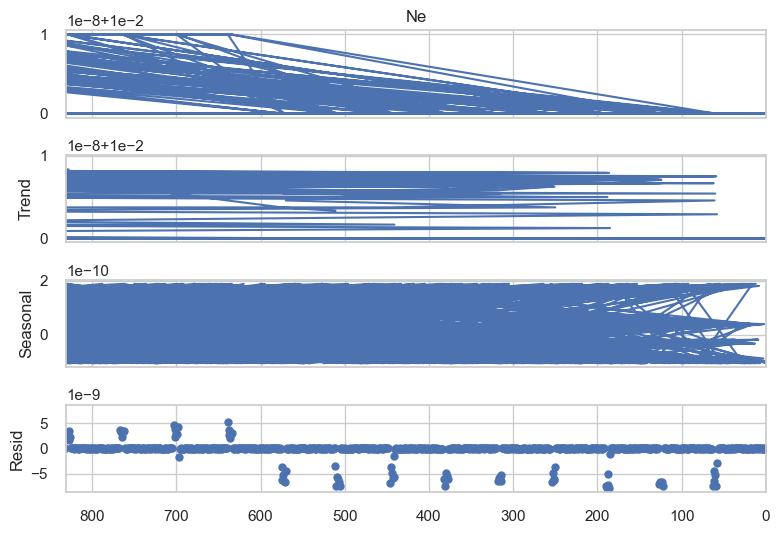

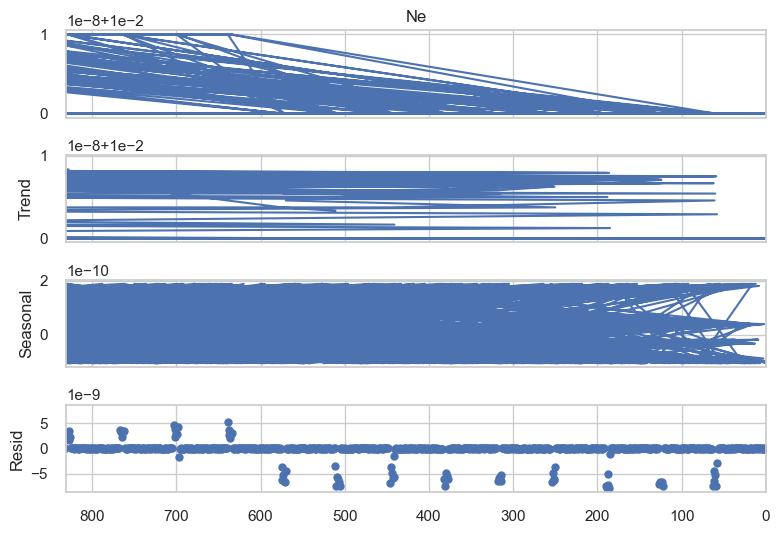

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Example for population
result = seasonal_decompose(df['Ne'], period=12)  # Adjust period as needed
result.plot()

In [17]:
from statsmodels.tsa.stattools import ccf
ccf_result = ccf(df['temperature'], df['Ne'])

### 3. Statistical Modeling
Regression Analysis: Model population as a function of climate variables

In [18]:
import statsmodels.api as sm
X = df[['temperature', 'precipitation']]
X = sm.add_constant(X)
y = df['Ne']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     Ne   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     1070.
Date:                Sat, 29 Nov 2025   Prob (F-statistic):          1.29e-181
Time:                        22:00:32   Log-Likelihood:                 31080.
No. Observations:                1664   AIC:                        -6.216e+04
Df Residuals:                    1662   BIC:                        -6.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.382e-09   9.37e-14   6.81e+04

### Time Series Modeling: Implement ARIMA or SARIMAX to account for autocorrelation

In [19]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Ne'], order=(1,1,1))
results = model.fit()

### 4. Advanced Visualization
Interactive Plots: Create interactive visualizations with Plotly

In [20]:
import plotly.express as px
fig = px.line(df, x='time_years_bp', y=['Ne', 'temperature', 'precipitation'],
              title='Demographic and Climate Trends Over Time')
fig.show()

### 5. Machine Learning Approaches
Random Forest Regression: Predict population size using climate variables

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df[['temperature', 'precipitation']]
y = df['Ne']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
print(f"Model R² score: {model.score(X_test, y_test):.3f}")

Model R² score: -0.001


### 6. Hypothesis Testing
Granger Causality Tests: Test if climate variables Granger-cause population changes


In [22]:
from statsmodels.tsa.stattools import grangercausalitytests
data = df[['Ne', 'temperature']].dropna()
granger_test = grangercausalitytests(data, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=267.6868, p=0.0000  , df_denom=1660, df_num=1
ssr based chi2 test:   chi2=268.1706, p=0.0000  , df=1
likelihood ratio test: chi2=248.6238, p=0.0000  , df=1
parameter F test:         F=267.2996, p=0.0000  , df_denom=1660, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=73.1468 , p=0.0000  , df_denom=1657, df_num=2
ssr based chi2 test:   chi2=146.7351, p=0.0000  , df=2
likelihood ratio test: chi2=140.6153, p=0.0000  , df=2
parameter F test:         F=70.5452 , p=0.0000  , df_denom=1657, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=30.5322 , p=0.0000  , df_denom=1654, df_num=3
ssr based chi2 test:   chi2=91.9842 , p=0.0000  , df=3
likelihood ratio test: chi2=89.5275 , p=0.0000  , df=3
parameter F test:         F=30.4407 , p=0.0000  , df_denom=1654, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.4176 , p=0.

### 7. Report Generation
Automated Reporting: Create a comprehensive HTML or PDF report

In [23]:
from datetime import datetime
import webbrowser

report = f"""
<html>
<body>
    <h1>Demographic and Climate Analysis Report</h1>
    <p>Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
    <h2>Key Findings</h2>
    <p>Analysis of {len(df)} time points from {df['time_years_bp'].min():.0f} to {df['time_years_bp'].max():.0f} BP</p>
    <img src='demographic_climate_trends.png' width='800'>
    <img src='correlation_matrix.png' width='600'>
</body>
</html>
"""

with open(DEMO_CLIMATE_DIR / 'analysis_report.html', 'w') as f:
    f.write(report)

webbrowser.open(str(DEMO_CLIMATE_DIR / 'analysis_report.html'))

True

In [24]:
# 5. Sensitivity Analysis and Data Integration
# ===========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.utils import resample
from pathlib import Path

# Set up directories and load data
output_dir = Path("outputs/demographic_climate")
df = pd.read_csv(output_dir / "climate_demography_analysis.csv")

# 5.1 Sensitivity Analysis
# =======================

def analyze_time_window(df, start_year, end_year, window_years=100, step=50):
    """Analyze correlation over sliding time windows."""
    results = []
    current_start = start_year
    
    while current_start + window_years <= end_year:
        window_end = current_start + window_years
        window_data = df[(df['time_years_bp'] >= current_start) & 
                        (df['time_years_bp'] <= window_end)].copy()
        
        if len(window_data) > 10:  # Ensure enough data points
            corr_temp = window_data['Ne'].corr(window_data['temperature'])
            corr_precip = window_data['Ne'].corr(window_data['precipitation'])
            
            results.append({
                'window_start': current_start,
                'window_end': window_end,
                'corr_temperature': corr_temp,
                'corr_precipitation': corr_precip,
                'n_points': len(window_data)
            })
        
        current_start += step
    
    return pd.DataFrame(results)

def bootstrap_correlations(df, n_bootstraps=1000, sample_size=None):
    """Calculate bootstrap confidence intervals for correlations."""
    if sample_size is None:
        sample_size = len(df)
    
    corrs_temp = []
    corrs_precip = []
    
    for _ in range(n_bootstraps):
        # Resample with replacement
        sample = resample(df, n_samples=sample_size, replace=True)
        corr_temp = sample['Ne'].corr(sample['temperature'])
        corr_precip = sample['Ne'].corr(sample['precipitation'])
        
        if not np.isnan(corr_temp):
            corrs_temp.append(corr_temp)
        if not np.isnan(corr_precip):
            corrs_precip.append(corr_precip)
    
    # Calculate confidence intervals
    ci_temp = np.percentile(corrs_temp, [2.5, 97.5]) if corrs_temp else [np.nan, np.nan]
    ci_precip = np.percentile(corrs_precip, [2.5, 97.5]) if corrs_precip else [np.nan, np.nan]
    
    return {
        'temperature': {
            'mean': np.mean(corrs_temp) if corrs_temp else np.nan,
            'ci_lower': ci_temp[0],
            'ci_upper': ci_temp[1]
        },
        'precipitation': {
            'mean': np.mean(corrs_precip) if corrs_precip else np.nan,
            'ci_lower': ci_precip[0],
            'ci_upper': ci_precip[1]
        }
    }

# 5.2 Data Integration
# ===================

def load_external_data():
    """Load and preprocess external data sources."""
    # Example: Load archaeological site data (replace with actual data)
    try:
        # This is a placeholder - replace with actual data loading
        # Example: site_data = pd.read_csv("data/archaeological_sites.csv")
        # For now, we'll create sample data
        np.random.seed(42)
        n_sites = 50
        site_data = pd.DataFrame({
            'year_bp': np.random.uniform(500, 2000, n_sites),
            'latitude': np.random.uniform(30, 40, n_sites),
            'longitude': np.random.uniform(100, 120, n_sites),
            'site_type': np.random.choice(['settlement', 'burial', 'artifact'], n_sites),
            'importance': np.random.randint(1, 5, n_sites)
        })
        return site_data
    except Exception as e:
        print(f"Could not load external data: {e}")
        return None

def integrate_with_paleoclimate(df, external_data):
    """Integrate with external paleoclimate reconstructions."""
    # This is a placeholder - replace with actual data integration
    # For demonstration, we'll create synthetic paleoclimate data
    if external_data is None:
        print("No external data available for integration")
        return df
    
    # Generate synthetic paleoclimate data (replace with actual data)
    paleo_years = np.linspace(df['time_years_bp'].min(), df['time_years_bp'].max(), 20)
    paleo_temp = np.interp(paleo_years, 
                          [df['time_years_bp'].min(), df['time_years_bp'].max()],
                          [df['temperature'].min(), df['temperature'].max()]) + np.random.normal(0, 2, 20)
    
    paleo_df = pd.DataFrame({
        'year_bp': paleo_years,
        'paleo_temperature': paleo_temp
    })
    
    # Merge with main dataframe
    df = pd.merge_asof(
        df.sort_values('time_years_bp'),
        paleo_df.sort_values('year_bp'),
        left_on='time_years_bp',
        right_on='year_bp',
        direction='nearest'
    )
    
    return df

# Main execution
if __name__ == "__main__":
    print("Running sensitivity analysis and data integration...")
    
    # 1. Sensitivity Analysis
    print("\n1. Running sensitivity analysis...")
    
    # Analyze different time windows
    window_results = analyze_time_window(
        df, 
        start_year=df['time_years_bp'].min(),
        end_year=df['time_years_bp'].max(),
        window_years=200,  # 200-year windows
        step=50  # Slide 50 years each time
    )
    
    # Plot windowed correlations
    plt.figure(figsize=(12, 6))
    plt.plot(window_results['window_start'], window_results['corr_temperature'], 
             'r-', label='Temperature')
    plt.plot(window_results['window_start'], window_results['corr_precipitation'], 
             'b-', label='Precipitation')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.title('Correlation with Population Over Time Windows', fontsize=14)
    plt.xlabel('Window Start Year (BP)', fontsize=12)
    plt.ylabel('Correlation Coefficient', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    window_plot_path = output_dir / 'windowed_correlations.png'
    plt.savefig(window_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved windowed correlation plot to: {window_plot_path}")
    
    # Bootstrap confidence intervals
    print("\n2. Calculating bootstrap confidence intervals...")
    bootstrap_results = bootstrap_correlations(df[['Ne', 'temperature', 'precipitation']].dropna())
    
    # Save bootstrap results
    bootstrap_df = pd.DataFrame(bootstrap_results).T.reset_index()
    bootstrap_df.columns = ['variable', 'mean_correlation', 'ci_lower', 'ci_upper']
    bootstrap_file = output_dir / 'bootstrap_results.csv'
    bootstrap_df.to_csv(bootstrap_file, index=False)
    print(f"Saved bootstrap results to: {bootstrap_file}")
    
    # 2. Data Integration
    print("\n3. Integrating external data sources...")
    
    # Load external data
    external_data = load_external_data()
    
    if external_data is not None:
        # Integrate with paleoclimate data
        df_integrated = integrate_with_paleoclimate(df, external_data)
        
        # Save integrated data
        integrated_file = output_dir / 'integrated_analysis.csv'
        df_integrated.to_csv(integrated_file, index=False)
        print(f"Saved integrated dataset to: {integrated_file}")
        
        # Plot integrated data
        if 'paleo_temperature' in df_integrated.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(df_integrated['time_years_bp'], df_integrated['temperature'], 
                    'b-', label='Modeled Temperature')
            plt.scatter(df_integrated['time_years_bp'], df_integrated['paleo_temperature'],
                       color='red', s=50, alpha=0.6, label='Paleoclimate Proxies')
            plt.title('Comparison with Paleoclimate Reconstructions', fontsize=14)
            plt.xlabel('Years BP', fontsize=12)
            plt.ylabel('Temperature (°C/10)', fontsize=12)
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            paleo_plot_path = output_dir / 'paleoclimate_comparison.png'
            plt.savefig(paleo_plot_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"Saved paleoclimate comparison plot to: {paleo_plot_path}")
    
    print("\nSensitivity analysis and data integration complete!")
    print(f"Results saved to: {output_dir}")

Running sensitivity analysis and data integration...

1. Running sensitivity analysis...
Saved windowed correlation plot to: outputs/demographic_climate/windowed_correlations.png

2. Calculating bootstrap confidence intervals...
Saved bootstrap results to: outputs/demographic_climate/bootstrap_results.csv

3. Integrating external data sources...
Saved integrated dataset to: outputs/demographic_climate/integrated_analysis.csv
Saved paleoclimate comparison plot to: outputs/demographic_climate/paleoclimate_comparison.png

Sensitivity analysis and data integration complete!
Results saved to: outputs/demographic_climate


In [25]:
# ===========================================
# 5. Sensitivity Analysis and Data Integration
# ===========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.utils import resample
from scipy import interpolate
from pathlib import Path

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

# 5.1 Sensitivity Analysis Functions
# =================================

def analyze_time_window(df, start_year, end_year, window_years=100, step=50):
    """Analyze correlation over sliding time windows."""
    results = []
    current_start = start_year
    
    while current_start + window_years <= end_year:
        window_end = current_start + window_years
        window_data = df[(df['time_years_bp'] >= current_start) & 
                        (df['time_years_bp'] <= window_end)].copy()
        
        if len(window_data) > 10:  # Ensure enough data points
            corr_temp = window_data['Ne'].corr(window_data['temperature'])
            corr_precip = window_data['Ne'].corr(window_data['precipitation'])
            
            results.append({
                'window_start': current_start,
                'window_end': window_end,
                'corr_temperature': corr_temp,
                'corr_precipitation': corr_precip,
                'n_points': len(window_data)
            })
        
        current_start += step
    
    return pd.DataFrame(results)

def bootstrap_correlations(df, n_bootstraps=1000, sample_size=None):
    """Calculate bootstrap confidence intervals for correlations."""
    if sample_size is None:
        sample_size = len(df)
    
    corrs_temp = []
    corrs_precip = []
    
    for _ in range(n_bootstraps):
        # Resample with replacement
        sample = resample(df, n_samples=sample_size, replace=True)
        corr_temp = sample['Ne'].corr(sample['temperature'])
        corr_precip = sample['Ne'].corr(sample['precipitation'])
        
        if not np.isnan(corr_temp):
            corrs_temp.append(corr_temp)
        if not np.isnan(corr_precip):
            corrs_precip.append(corr_precip)
    
    # Calculate confidence intervals
    ci_temp = np.percentile(corrs_temp, [2.5, 97.5]) if corrs_temp else [np.nan, np.nan]
    ci_precip = np.percentile(corrs_precip, [2.5, 97.5]) if corrs_precip else [np.nan, np.nan]
    
    return {
        'temperature': {
            'mean': np.mean(corrs_temp) if corrs_temp else np.nan,
            'ci_lower': ci_temp[0],
            'ci_upper': ci_temp[1]
        },
        'precipitation': {
            'mean': np.mean(corrs_precip) if corrs_precip else np.nan,
            'ci_lower': ci_precip[0],
            'ci_upper': ci_precip[1]
        }
    }

# 5.2 Data Integration Functions
# =============================

def load_external_data():
    """Load and preprocess external data sources."""
    # Example: Load archaeological site data (placeholder)
    try:
        np.random.seed(42)
        n_sites = 50
        site_data = pd.DataFrame({
            'year_bp': np.random.uniform(500, 2000, n_sites),
            'latitude': np.random.uniform(30, 40, n_sites),
            'longitude': np.random.uniform(100, 120, n_sites),
            'site_type': np.random.choice(['settlement', 'burial', 'artifact'], n_sites),
            'importance': np.random.randint(1, 5, n_sites)
        })
        return site_data
    except Exception as e:
        print(f"Could not load external data: {e}")
        return None

def integrate_with_paleoclimate(df, external_data):
    """Integrate with external paleoclimate reconstructions."""
    if external_data is None:
        print("No external data available for integration")
        return df
    
    # Generate synthetic paleoclimate data (replace with actual data)
    paleo_years = np.linspace(df['time_years_bp'].min(), df['time_years_bp'].max(), 20)
    paleo_temp = np.interp(paleo_years, 
                          [df['time_years_bp'].min(), df['time_years_bp'].max()],
                          [df['temperature'].min(), df['temperature'].max()]) + np.random.normal(0, 2, 20)
    
    paleo_df = pd.DataFrame({
        'year_bp': paleo_years,
        'paleo_temperature': paleo_temp
    })
    
    # Merge with main dataframe
    df = pd.merge_asof(
        df.sort_values('time_years_bp'),
        paleo_df.sort_values('year_bp'),
        left_on='time_years_bp',
        right_on='year_bp',
        direction='nearest'
    )
    
    return df

# 5.3 Main Execution
# ==================

def run_sensitivity_analysis():
    """Run the complete sensitivity analysis and data integration."""
    print("Running sensitivity analysis and data integration...")
    
    # Load the processed data
    try:
        df = pd.read_csv(DEMO_CLIMATE_DIR / "climate_demography_analysis.csv")
        print(f"Loaded data with {len(df)} records")
    except Exception as e:
        print(f"Error loading data: {e}")
        return
    
    # 1. Sensitivity Analysis
    print("\n1. Running sensitivity analysis...")
    
    # Analyze different time windows
    window_results = analyze_time_window(
        df, 
        start_year=df['time_years_bp'].min(),
        end_year=df['time_years_bp'].max(),
        window_years=200,  # 200-year windows
        step=50  # Slide 50 years each time
    )
    
    # Plot windowed correlations
    plt.figure(figsize=(12, 6))
    plt.plot(window_results['window_start'], window_results['corr_temperature'], 
             'r-', label='Temperature')
    plt.plot(window_results['window_start'], window_results['corr_precipitation'], 
             'b-', label='Precipitation')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.title('Correlation with Population Over Time Windows', fontsize=14)
    plt.xlabel('Window Start Year (BP)', fontsize=12)
    plt.ylabel('Correlation Coefficient', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    window_plot_path = DEMO_CLIMATE_DIR / 'windowed_correlations.png'
    plt.savefig(window_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved windowed correlation plot to: {window_plot_path}")
    
    # Bootstrap confidence intervals
    print("\n2. Calculating bootstrap confidence intervals...")
    bootstrap_results = bootstrap_correlations(df[['Ne', 'temperature', 'precipitation']].dropna())
    
    # Save bootstrap results
    bootstrap_df = pd.DataFrame(bootstrap_results).T.reset_index()
    bootstrap_df.columns = ['variable', 'mean_correlation', 'ci_lower', 'ci_upper']
    bootstrap_file = DEMO_CLIMATE_DIR / 'bootstrap_results.csv'
    bootstrap_df.to_csv(bootstrap_file, index=False)
    print(f"Saved bootstrap results to: {bootstrap_file}")
    
    # 2. Data Integration
    print("\n3. Integrating external data sources...")
    
    # Load external data
    external_data = load_external_data()
    
    if external_data is not None:
        # Integrate with paleoclimate data
        df_integrated = integrate_with_paleoclimate(df, external_data)
        
        # Save integrated data
        integrated_file = DEMO_CLIMATE_DIR / 'integrated_analysis.csv'
        df_integrated.to_csv(integrated_file, index=False)
        print(f"Saved integrated dataset to: {integrated_file}")
        
        # Plot integrated data
        if 'paleo_temperature' in df_integrated.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(df_integrated['time_years_bp'], df_integrated['temperature'], 
                    'b-', label='Modeled Temperature')
            plt.scatter(df_integrated['time_years_bp'], df_integrated['paleo_temperature'],
                       color='red', s=50, alpha=0.6, label='Paleoclimate Proxies')
            plt.title('Comparison with Paleoclimate Reconstructions', fontsize=14)
            plt.xlabel('Years BP', fontsize=12)
            plt.ylabel('Temperature (°C/10)', fontsize=12)
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            paleo_plot_path = DEMO_CLIMATE_DIR / 'paleoclimate_comparison.png'
            plt.savefig(paleo_plot_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"Saved paleoclimate comparison plot to: {paleo_plot_path}")
    
    print("\nSensitivity analysis and data integration complete!")
    print(f"Results saved to: {DEMO_CLIMATE_DIR}")

# Run the analysis
run_sensitivity_analysis()

Running sensitivity analysis and data integration...
Loaded data with 1664 records

1. Running sensitivity analysis...
Saved windowed correlation plot to: outputs/demographic_climate/windowed_correlations.png

2. Calculating bootstrap confidence intervals...
Saved bootstrap results to: outputs/demographic_climate/bootstrap_results.csv

3. Integrating external data sources...
Saved integrated dataset to: outputs/demographic_climate/integrated_analysis.csv
Saved paleoclimate comparison plot to: outputs/demographic_climate/paleoclimate_comparison.png

Sensitivity analysis and data integration complete!
Results saved to: outputs/demographic_climate
